# two asset ikc model

In [16]:
using LinearAlgebra
using BenchmarkTools
using ProgressMeter        # show progress of each loop with: @showprogress 1 "Computing..." for i in 1:50
using Parameters
using Interpolations
using Base.Threads
using Plots
using SparseArrays
using BasisMatrices

include("functions.jl")

interpolate_coord (generic function with 1 method)

In [17]:

@with_kw mutable struct params
    # Households
    β::Float64  = 0.976    # Discount factor 
    σ::Float64  = 2        # Inverse IES
    χ0::Float64 = 0.25     # Portfolio adj. cost pivot 
    χ1::Float64 = 6.416    # Portfolio adj. cost scale 
    χ2::Float64 = 2        # Portfolio adj. cost curvature
    ρe::Float64 = 0.966    # Autocorrelation of earnings
    σe::Float64 = 0.92     # Cross-sectional std of log earnings
    μe::Float64 = 0.000    # mean of earnings
    min_a::Float64 = 0     # borrowing limit for illiquid asset
    min_b::Float64 = 0     # borrowing limit for liquid asset
    min_k::Float64 = 0     # min limit for kappa grid
    max_a::Float64 = 2000  # max limit for illiquid asset
    max_b::Float64 = 50    # max limit for liquid asset
    max_k::Float64 = 1     # max limit for kappa grid
    r::Float64  = 0.0125     # Real interest rate
    ζ::Float64  = 0.08/(1.05) # Illiquid-liquid spread
    # Labor Unions
    ϕ::Float64  = 2.073    # Disutility of labor
    ν::Float64  = 1        # Inverse Frisch elasticity
    μw::Float64 = 1.1      # Steady state wage markup
    κw::Float64 = 0.1      # Slope of wage Phillips curve
    # Firms
    Z::Float64  = 0.468    # TFP
    α::Float64  = 0.33     # Capital share
    μp::Float64 = 1.015    # Steady-state markup 
    δ::Float64  = 0.02     # Depreciation
    κp::Float64 = 0.1      # Slope of price Phillips curve 
    # # Financial intermediary
    # ω::Float64 = 0.005     # Liquidity premium
    # # policy
    # τ::Float64  = 0.356     # Labor tax
    # G::Float64  = 0.2       # Government spending
    # Bg::Float64 = 2.8       # Bond supply
    # Φ::Float64  = 1.5       # Taylor rule coefficien
    # Φy::Float64 = 0         # Taylor rule coefficient on output
    # Discretization
    na::Int = 60        # Number of grid points for illiquid asset
    nb::Int = 50        # Number of grid points for liquid asset
    nk::Int = 40        # Number of grid points for kappa
    nz::Int = 3         # Number of grid points for idiosyncratic income process 
    # grids
    a::Vector{Float64} = zeros(1)
    b::Vector{Float64} = zeros(1)
    aθ::Float64 = 5.0
    bθ::Float64 = 2.0
    y::Vector{Float64} = zeros(1)
    k::Vector{Float64} = zeros(1)
    z_p::Array{Float64, 2} = zeros(1,1)
    # policy
    Va::Array{Float64, 3} = zeros(1,1,1)
    Vb::Array{Float64, 3} = zeros(1,1,1)
    c_pol::Array{Float64, 3} = zeros(1,1,1)
    a_pol::Array{Float64, 3} = zeros(1,1,1)
    b_pol::Array{Float64, 3} = zeros(1,1,1)
    # dist
    Λ::SparseMatrixCSC{Float64,Int64} = spzeros(na,nb)
    dist::Vector{Float64} = ones(na*nb*nz)/(na*nb*nz)
end

pr = params(); #parameters of the model


In [18]:
# Initializing grids
pr.a, pr.b, pr.k, z, pr.z_p = grid_maker(pr)
pi = stationary(pr.z_p)
pr.y = exp.(z) ./ (pi'*exp.(z))

3-element Vector{Float64}:
 0.00016801993082933588
 0.025756480514065462
 3.9483190190410817

In [ ]:



















# update derivatives of value function using envelope conditions
Va_new = (1 .+ r .- Psi2) .* uc
Vb_new = ((1+r)*(1-ζ)) .* uc

if maximum(abs.(Va_new.-Va)) < 1e-7 && maximum(abs.(Vb_new.-Vb)) < 1e-7
    print("loop ended in iteration ",i)
    pr.Va = Va
    pr.Vb = Vb
    pr.c_pol = c_pol
    pr.a_pol = a_pol
    pr.b_pol = b_pol
    # break
end
Va = copy(Va_new)
Vb = copy(Vb_new)


3×50×60 Array{Float64, 3}:
[:, :, 1] =
    3.58652e7  1399.55      315.15      …  0.0027306   0.00220228  0.00177593
 1526.24        367.551     149.595        0.00279112  0.00225173  0.00181627
    0.145918      0.144429    0.142797     0.00216173  0.00178333  0.00146791

[:, :, 2] =
 -321.763     -45.3033    -10.164     …  0.0022492   0.00181517  0.00146458
  -48.6196    -12.5544     -2.32869      0.00229976  0.00185644  0.00149822
    0.121748    0.120502    0.119137     0.00179336  0.00147931  0.00121757

[:, :, 3] =
 -246.971    -42.041     -10.6962    …  0.00224557  0.00181254  0.00146267
  -44.8027   -12.8987     -3.14063      0.00229602  0.00185372  0.00149625
    0.12033    0.119107    0.117765     0.00179079  0.00147738  0.00121612

;;; … 

[:, :, 58] =
 -8.57465e-6  -8.56891e-6  -8.56252e-6  …  -3.25765e-6  -2.93119e-6
 -8.24753e-6  -8.24194e-6  -8.23572e-6     -3.07208e-6  -2.75492e-6
 -7.79002e-6  -7.78491e-6  -7.77924e-6     -2.99536e-6  -2.69585e-6

[:, :, 59] =
 -6.3219

## policy function solutions:

In [63]:
# EGM
function EGM_solve!(pr)
    @unpack σ, β, ζ, r, k, b, a, y, z_p, nk, nb, na, nz, min_a, min_b = pr
    # step 0: initialize value function
    A_3d = reshape(pr.a, (length(pr.a), 1, 1))
    B_3d = reshape(pr.b, (1, length(pr.b), 1))
    Y_3d = reshape(pr.y, (1, 1, length(pr.y)))
    
    Va = (0.6 .+       (A_3d.-pr.min_a) .+ 1.1 .* (B_3d.-pr.min_b) .+ 0.2 .* Y_3d) .^ (-pr.σ)
    Vb = (0.5 .+ 1.2 .*(A_3d.-pr.min_a) .+        (B_3d.-pr.min_b) .+ 0.2 .* Y_3d) .^ (-pr.σ)
    # precompute Psi1(a', a) on grid of (a', a) for steps 3 and 5 (adjustment cost)
    Psi, Psi1, Psi2 = get_Psi_and_deriv(pr.a, pr.a', pr)

    for i in 1:1000
        # === STEP 2: Wb(z, b', a') and Wa(z, b', a') ===
        # (take discounted expectation of tomorrow's value function)
        Wb = β * reshape(reshape(Vb, :, nz) * z_p, na, nb, nz )
        Wa = β * reshape(reshape(Va, :, nz) * z_p, na, nb, nz )
        W_ratio = Wa ./ Wb

        # === STEP 3: a'(z, b', a) for UNCONSTRAINED ===

        # for each (z, b', a), linearly interpolate to find a' between gridpoints
        # satisfying optimality condition W_ratio == 1+Psi1
        idx, pi = lhs_equals_rhs_interpolate(W_ratio, 1 .+ Psi1)
        # use same interpolation to get Wb and then c
        a_endo_unc = apply_coord(idx, pi, a)
        temp = similar(a_endo_unc)
        for i in 1:nz
            for j in 1:nb
                temp[:,j,i] = apply_coord(idx[:,j,i], pi[:,j,i], Wb[:,j,i]).^ (-1/σ)
            end
        end
        c_endo_unc = temp

        # === STEP 4: b'(z, b, a), a'(z, b, a) for UNCONSTRAINED ===
        # solve out budget constraint to get b(z, b', a)
        b_endo = (c_endo_unc + a_endo_unc + repeat(B_3d,na,1,nz) - repeat(A_3d.*(1+r),1,nb,nz) - repeat(Y_3d,na,nb,1) + reshape(get_Psi_and_deriv(reshape(a_endo_unc,na,:)', a', pr)[1]',na,nb,nz) ) / ((1+r)*(1-ζ))


        # interpolate this b' -> b mapping to get b -> b', so we have b'(z, b, a)
        # and also use interpolation to get a'(z, b, a)
        # (note utils.interpolate.interpolate_coord and utils.interpolate.apply_coord work on last axis,
        #  so we need to swap 'b' to the last axis, then back when done)
        for i in 1:nz
            for j in 1:na
                idx[j,:,i], pi[j,:,i] = interpolate_coord(b_endo[j,:,i],b)
            end
        end
        temp = similar(a_endo_unc)
        for i in 1:nz
            for j in 1:na
                temp[j,:,i] = apply_coord(idx[j,:,i], pi[j,:,i], a_endo_unc[j,:,i])
            end
        end
        a_unc = temp
        b_unc = apply_coord(idx, pi, b);

        # === STEP 5: a'(z, kappa, a) for CONSTRAINED ===
        # for each (z, kappa, a), linearly interpolate to find a' between gridpoints
        # satisfying optimality condition W_ratio/(1+kappa) == 1+Psi1, assuming b'=0
        lhs_con = W_ratio[:, 1:1, :] ./ (1 .+ reshape(k,1,nk,1))
        idx, pi = lhs_equals_rhs_interpolate(lhs_con, (1 .+ Psi1) )
        # use same interpolation to get Wb and then c
        a_endo_con = apply_coord(idx, pi, a)
        temp = similar(a_endo_con)
        for i in 1:nz
            for j in 1:nk
                temp[:,j,i] = apply_coord(idx[:,j,i], pi[:,j,i], Wb[:, 1, i])
            end
        end
        c_endo_con = ( (1 .+ reshape(k,1,nk,1)).^(-1/σ) .* (temp).^(-1/σ) )

        # === STEP 6: a'(z, b, a) for CONSTRAINED ===
        # solve out budget constraint to get b(z, kappa, a), enforcing b'=0
        b_endo_con = (c_endo_con + a_endo_con
                + repeat([b[1]],na,nk,nz) - repeat(A_3d.*(1+r),1,nk,nz) - repeat(Y_3d,na,nk,1)
                + reshape(get_Psi_and_deriv(reshape(a_endo_con,na,:)', a', pr)[1]',na,nk,nz) ) / ((1+r)*(1-ζ))
        # interpolate this kappa -> b mapping to get b -> kappa
        # then use the interpolated kappa to get a', so we have a'(z, b, a)
        # (utils.interpolate.interpolate_y does this in one swoop, but since it works on last
        # axis, we need to swap kappa to last axis, and then b back to middle when done)
        a_con = zeros(na, nb, nz)
        for i in 1:nz
            for j in 1:na
                a_con[j,:,i] = interpolate_f(b_endo_con[j,:,i], a_endo_con[j,:,i], b)
            end
        end

        # === STEP 7: obtain policy functions and update derivatives of value function ===
        # combine unconstrained solution and constrained solution, choosing latter
        # when unconstrained goes below minimum b
        a_pol = copy(a_unc) 
        b_pol = copy(b_unc)
        b_pol[b_pol .<= b[1]] .= b[1]
        a_pol[b_pol .<= b[1]] = a_con[b_pol .<= b[1]]
        # calculate adjustment cost and its derivative
        Psi, temp, Psi2 = get_Psi_and_deriv(reshape(a_pol,na,:)', a', pr)
        Psi  = reshape(Psi', na, nb, nz)
        Psi2 = reshape(Psi2', na, nb, nz)
        # solve out budget constraint to get consumption and marginal utility
        c_pol = repeat(B_3d.*(1+r).*(1-ζ),na,1,nz) + repeat(A_3d.*(1+r),1,nb,nz) + repeat(Y_3d,na,nb,1) - Psi - a_pol - b_pol
        uc = c_pol .^ (-σ)

        # update derivatives of value function using envelope conditions
        Va_new = (1 .+ r .- Psi2) .* uc
        Vb_new = ((1+r)*(1-ζ)) .* uc

        if maximum(abs.(Va_new.-Va)) < 1e-7 && maximum(abs.(Vb_new.-Vb)) < 1e-7
            print("loop ended in iteration ",i)
            pr.Va = Va
            pr.Vb = Vb
            pr.c_pol = c_pol
            pr.a_pol = a_pol
            pr.b_pol = b_pol
            break
        end
        Va = copy(Va_new)
        Vb = copy(Vb_new)
    end
end

EGM_solve! (generic function with 1 method)

In [64]:
EGM_solve!(pr::params)

loop ended in iteration 540

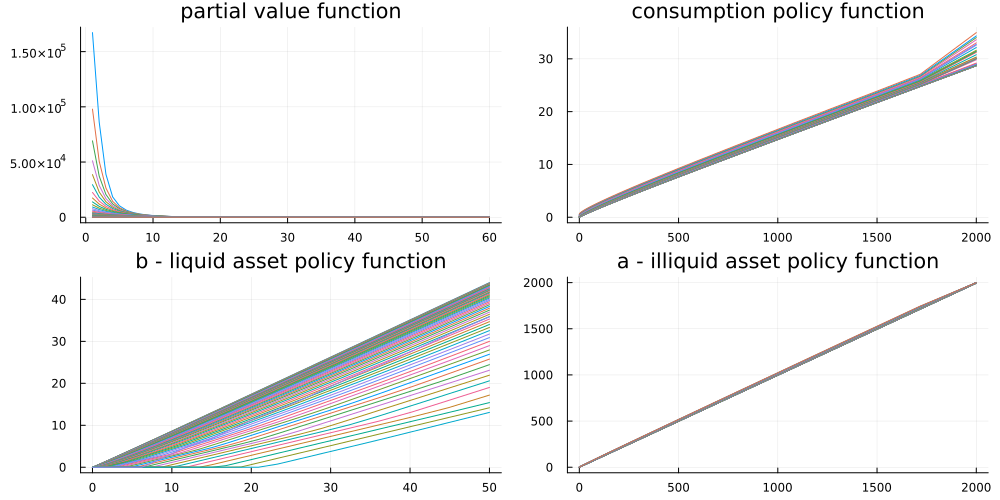

In [68]:
s = 2
p_v = plot(pr.Va[:,:,s], legend = false, title="partial value function")
p_c = plot(pr.a,pr.c_pol[:,:,s], legend = false, title="consumption policy function")
p_b = plot(pr.b,pr.b_pol[:,:,s]', legend = false, title="b - liquid asset policy function")
p_a = plot(pr.a,pr.a_pol[:,:,s], legend = false, title="a - illiquid asset policy function" )
plot(p_v,p_c,p_b,p_a, layout=(2,2), size = (1000,500))

## Distribution matrices

Using lottery method by Young(2010)

In [ ]:
# basis = Basis(SplineParams(pr.a, 0, 1),SplineParams(pr.b, 0, 1))
# S, (agrid, ygrid) = nodes(basis)

# Φ_direct = BasisMatrix(basis, Direct(),S)
# Φ = convert(Expanded, Φ_direct).vals[1]

# λ = Φ\reshape(pr.a_pol[2,:,:],:,1)
# Φ * λ;


In [71]:
function transitionMartixMaker!(pr)
    @unpack a, b, z_p, nz = pr
    basis = Basis(SplineParams(pr.a, 0, 1),SplineParams(pr.b, 0, 1))
    temp = [kron(z_p[s,:], convert(Expanded, BasisMatrix(Basis(basis),Direct(), [reshape(pr.a_pol[:,:,s],:,1)  reshape(pr.b_pol[:,:,s],:,1) ] ) ).vals[1]' ) for s in 1:pr.nz]
    pr.Λ = hcat(temp...)
end

function distFinder(pr)
    @unpack nz,Λ,dist = pr
    diff = 1
    tol = 1e-8
    dist_new = copy(dist)
    for i = 1:10000
        mul!(dist_new,Λ,dist)
        if i%100 == 0
            diff = norm(dist_new - dist, Inf)
            if diff < tol
                break
            end
        end
        dist .= dist_new
    end
    return pr.dist = dist
end

transitionMartixMaker!(pr);
dist_new = distFinder(pr)


9000-element Vector{Float64}:
 4.2182236874884903e-7
 8.240658046937528e-6
 2.8843537557660313e-5
 6.0277411496448745e-5
 0.00010134149468229807
 0.00015268378982966866
 0.0002154988711547773
 0.00029069603487532437
 0.0003783412737937006
 0.0004771600351202304
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

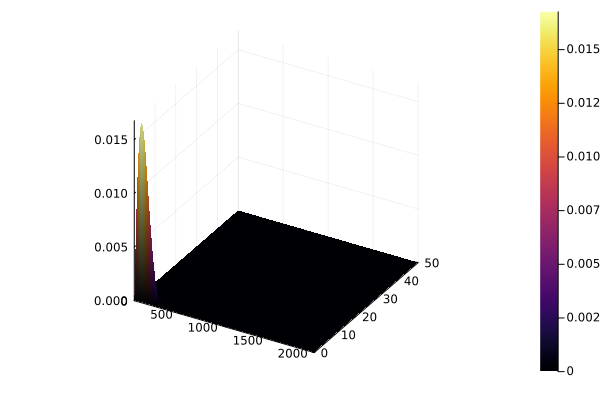

In [72]:
dist_p = reshape(dist_new, pr.na, pr.nb, pr.nz)

# draw first n = 20 first 
na = pr.na
nb = pr.nb
surface(a[1:na], b[1:nb], dist_p[1:na,1:nb,1]')

In [29]:
@unpack a, b, z_p = pr
PI_a = zeros(pr.nz, pr.nb, pr.na, pr.nz, pr.nb, pr.na)
for i in 1:pr.nz
    for j in 1:pr.nb
        for k in 1:pr.na
            policy = pr.a_pol[i,j,k];
            indx = searchsortedlast(a, policy, lt= <)
            # write an if for indx== 0 or 70
            if indx==pr.na
                indx = indx - 1;
            end
            PI_a[i,j,k,:,:,indx]   .= (a[indx+1] - policy) / (a[indx+1]-a[indx])
            PI_a[i,j,k,:,:,indx+1] .= (policy - a[indx]) / (a[indx+1]-a[indx])
        end
    end
end

PI_b = zeros(pr.nz, pr.nb, pr.na, pr.nz, pr.nb, pr.na)
for i in 1:pr.nz
    for j in 1:pr.nb
        for k in 1:pr.na
            policy = pr.b_pol[i,j,k];
            indx = searchsortedlast(b, policy, lt= <)
            # write an if for indx== 0 or 70
            if indx==pr.nb
                indx = indx - 1;
            end
            PI_b[i,j,k,:,indx,:]   .= (b[indx+1] - policy) / (b[indx+1]-b[indx])
            PI_b[i,j,k,:,indx+1,:] .= (policy - b[indx]) / (b[indx+1]-b[indx])
        end
    end
end

PI_z = zeros(pr.nz, pr.nb, pr.na, pr.nz, pr.nb, pr.na)
for i in 1:pr.nz
    for j in 1:pr.nb
        for k in 1:pr.na
            for indx in 1:pr.nz
                PI_z[i,j,k,indx,:,:] .= z_p[i,indx]
            end
        end
    end
end

PI = PI_a .* PI_b .* PI_z;
PI = sparse(reshape(PI, pr.nz * pr.nb * pr.na, :));

In [24]:
dist = zeros(pr.nz * pr.nb * pr.na)'
dist[1,10,1] = 1

@showprogress for i in 1:10000
    dist_new = dist * PI
    if maximum(abs.(dist_new - dist)) < 1e-9
        print("reach to stationary dist after ",i," iterations.")
        break
    end
    dist = copy(dist_new)
end
dist = dist ./ sum(dist)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


reach to stationary dist after 2072 iterations.

1×9000 Matrix{Float64}:
 4.22522e-7  2.77114e-8  3.52872e-10  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

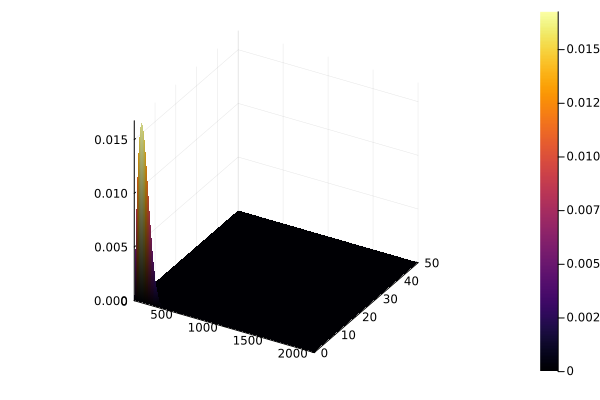

In [25]:
dist = reshape(dist, pr.nz, pr.nb, pr.na)

# draw first n = 20 first 
na = pr.na
nb = pr.nb
surface(a[1:na], b[1:nb], dist[1,1:nb,1:na])

In [257]:
sum(dist)

1.0

In [296]:
dist[1,:,:]

50×60 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0          …  7.84043e-8  0.000705812  0.0052822
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0          …  0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0         0.0          0.0
 ⋮                        ⋮            ⋱                           
 0.0  0.0  0.0  0.0  0.0  1.35338e-6      0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  1.77659e-10     0.0         0.0          0.0
 0.0  0.0  0.0  0.0  0.0  0.0             0.0      

## mpc matrices